In [1]:
#|default_exp activations

# Activations stats

In [2]:
#|export
from __future__ import annotations
import math
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import * 

In [3]:
import torch.nn.functional as F
from pathlib import Path
from operator import attrgetter, itemgetter

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close
from IPython.core.debugger import set_trace

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
import logging; logging.disable(logging.WARNING)

In [5]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [6]:
x,y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [7]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8),   # 14x14
        conv(8, 16),  # 7x7
        conv(16, 32), # 4x4
        conv(32, 64), # 2x2
        conv(64, 10, act=False), #1x1
        nn.Flatten()]

In [8]:
from torcheval.metrics import MulticlassAccuracy

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [10]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


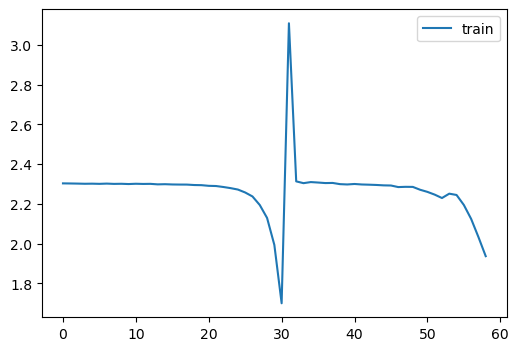

In [11]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


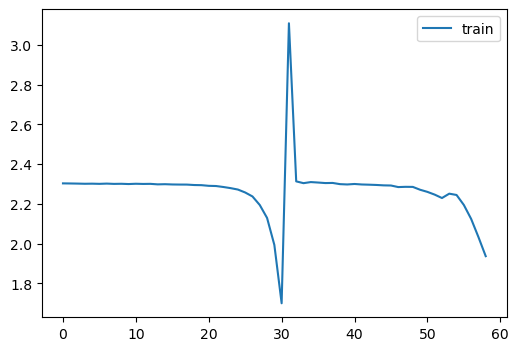

In [13]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

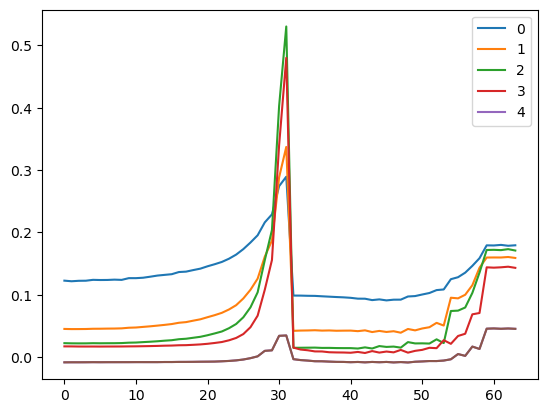

In [14]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

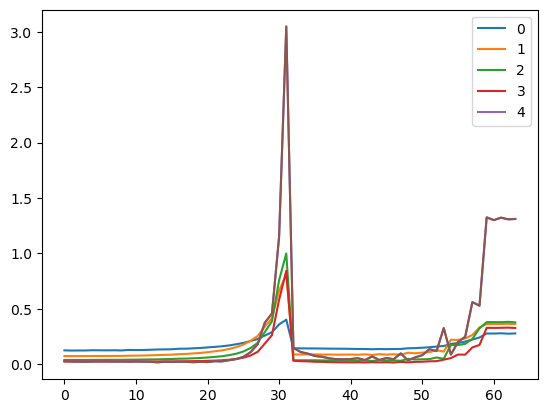

In [15]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5))

### Hooks

In [16]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [17]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [18]:
def append_stats(i, model, inp, out):
    act_means[i].append(to_cpu(out).mean())
    act_stds[i].append(to_cpu(out).std())

In [19]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


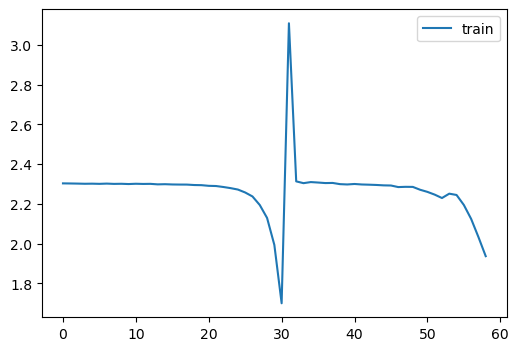

In [20]:
fit(model)

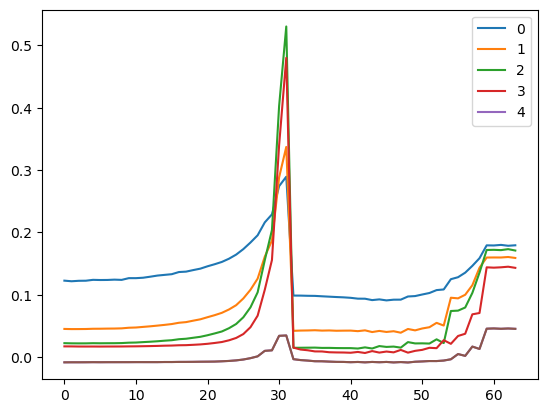

In [21]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

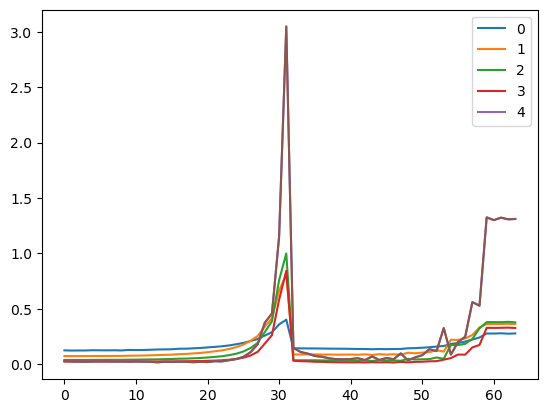

In [22]:
for o in act_stds: plt.plot(o)
plt.legend(range(5))

In [34]:
#|export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [35]:
def append_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [36]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [37]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


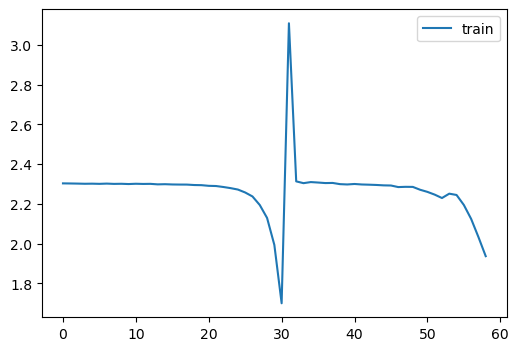

In [38]:
learn = fit(model)

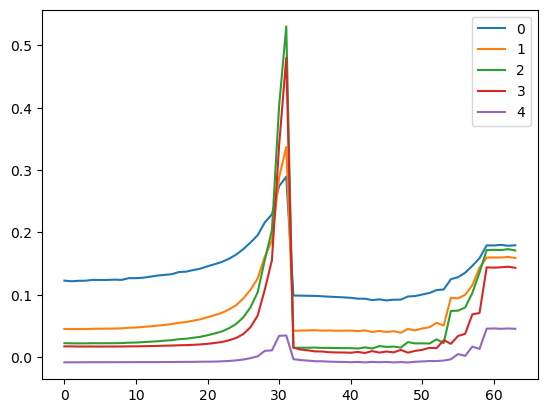

In [39]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

In [40]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self

    def __exit__(self, *args): self.remove()
    def remove(self): 
        for h in self: h.remove()

    def __del__(self): self.remove()
    def __delitem__(self, i): 
        self[i].remove()
        super().__delitem__(i)

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


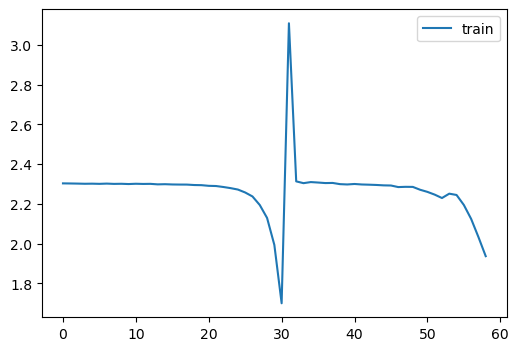

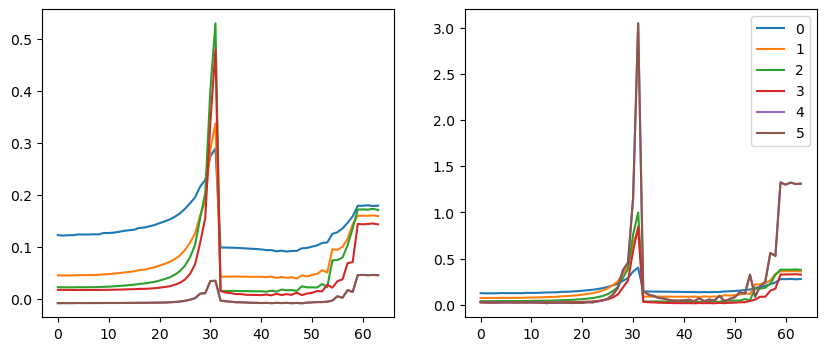

In [41]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks:
        for i in 0,1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6))

## HooksCB